In [1]:
import matplotlib.pyplot as pl
import matplotlib.colors as colors

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from haversine import inverse_haversine, Direction

import helpers as hlp
from spatial_tools import Projection, is_inside

In [2]:
"""
Read LES results.
"""
path = '/home/scratch1/bart/microhh/papers/dust_mahrooz_dirk/v2/large/'

# Read post-processed cross-sections.
ds1 = xr.open_dataset(f'{path}/20220510/stats.xy.nc', decode_times=False)
ds2 = xr.open_dataset(f'{path}/20220622/stats.xy.nc', decode_times=False)

In [3]:
"""
Spatial projection used by LES.
"""

xsize = 76800
ysize = 76800
itot = 768
jtot = 768

proj1 = Projection(
        xsize = xsize,
        ysize = ysize,
        itot = itot,
        jtot = jtot,
        lon = 7.4,
        lat = 53.05,
        anchor = 'center')

proj2 = Projection(
        xsize = xsize,
        ysize = ysize,
        itot = itot,
        jtot = jtot,
        lon = 6.5,
        lat = 53.1,
        anchor = 'center')

margin = 0.01
extent1 = [proj1.lon.min()-margin, proj1.lon.max()+margin-0.25, proj1.lat.min()-margin+0.05, proj1.lat.max()+margin-0.10]
extent2 = [proj2.lon.min()-margin+0.25, proj2.lon.max()+margin, proj2.lat.min()-margin+0.04, proj2.lat.max()+margin-0.11]

In [4]:
"""
Plot functions for deposition maps.
"""
zoom_level = 8
cmap = hlp.get_cmap_wbyr()
cmapa = hlp.add_transparancy_to_cmap(cmap, p=0.3)

def finish_plot(ax, extent, labels):
    """
    Add grid lines and spatial scale indicator to map.
    """
    # Add lat/lon labels and grid lines.
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.5,
        linestyle=':')
    
    for side in ['top', 'bottom', 'left', 'right']:
        setattr(gl, f'{side}_labels', side in labels)

    # Add scale indicator.
    start = (extent[2] + 0.9 * (extent[3] - extent[2]), extent[0] + 0.1 * (extent[1] - extent[0]))
    end = inverse_haversine(start, 20, Direction.EAST)

    x = np.array([start[1], end[1]])
    y = np.array([start[0], end[0]])

    pl.plot(x, y, 'k-|', linewidth=1, transform=ccrs.PlateCarree())
    pl.text(x.mean(), y.mean() + 0.01 * (extent[3] - extent[2]), '20 km', ha='center', transform=ccrs.PlateCarree())


def plot_bsne_normed(ds, proj, size, sp, extent, normed=False, labels=['bottom', 'left']):
    """
    Plot single panel, optionally normalized with virtual BSNE concentration at 1.
    """
    norm = colors.LogNorm(vmin=1e-3, vmax=1e6)
    var = 'deposition_n' if normed else 'deposition'

    ax = hlp.setup_map(extent, sp=sp, zoom_level=zoom_level, use_osm=True)
    pl.title(rf'{size} $\mu$m', loc='left')
    pc=pl.pcolormesh(proj.lon, proj.lat, -ds[f'{size}um_{var}'], cmap=cmapa, norm=norm, transform=ccrs.PlateCarree())

    finish_plot(ax, extent, labels)

    return pc


def plot_local_normed(ds, proj, mask, size, sp, extent, labels=['bottom', 'left']):
    """
    Plot single panel, with deposition normalized by the 500 m radius mean deposition.
    """
    cnorm = colors.LogNorm(vmin=1e-2, vmax=100)

    ax = hlp.setup_map(extent, sp=sp, zoom_level=zoom_level, use_osm=True)
    pl.title(rf'{size} $\mu$m', loc='left')

    field = -ds[f'{size}um_deposition'].values
    norm = field[mask].mean()

    pc=pl.pcolormesh(proj.lon, proj.lat, (field/norm)*100, cmap=cmapa, norm=cnorm, transform=ccrs.PlateCarree())

    finish_plot(ax, extent, labels)

    return pc

## No normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s, no normalization applied.

Shows deposition patterns if all dust sizes have the same surface flux.

Text(0, 0.5, '24 h total deposition ($\\mu g$ m$^{-2}$)')

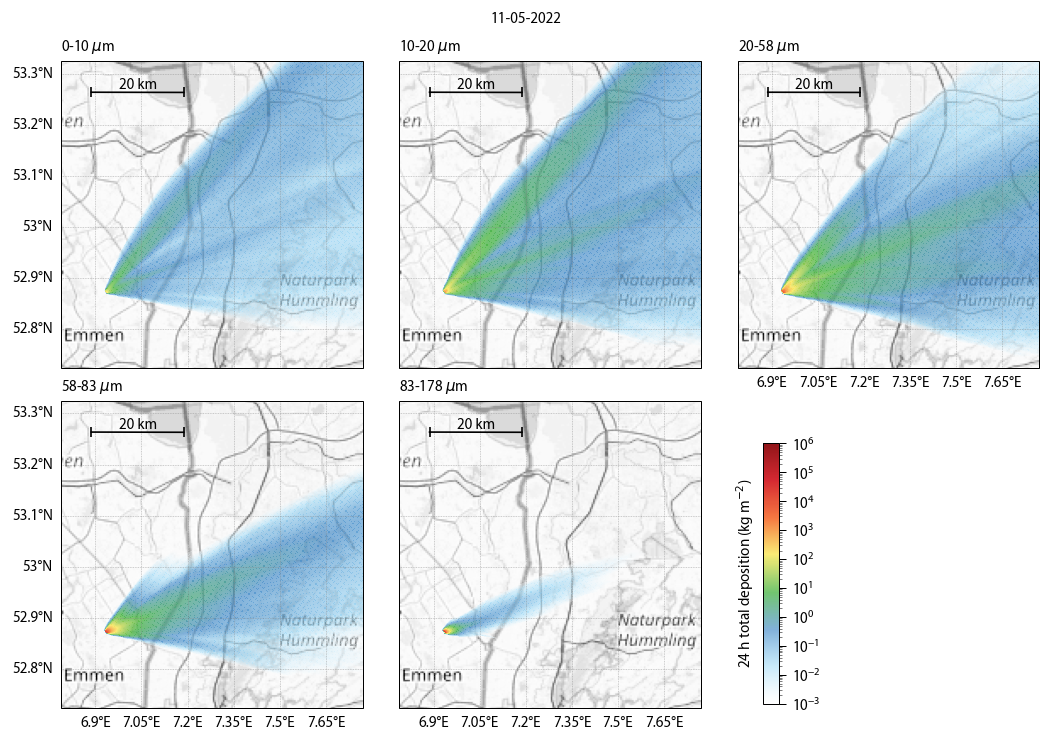

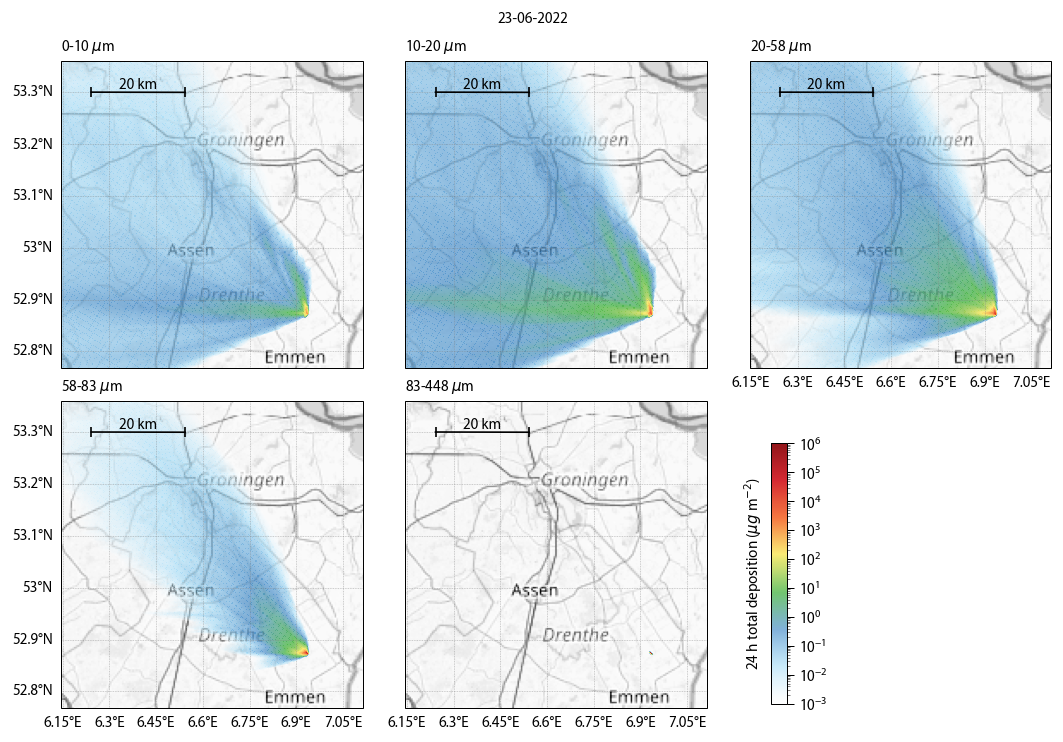

In [5]:
normalized = False

fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_bsne_normed(ds1, proj1, '0-10',   231, extent1, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds1, proj1, '10-20',  232, extent1, normed=normalized, labels=[])
pc=plot_bsne_normed(ds1, proj1, '20-58',  233, extent1, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds1, proj1, '58-83',  234, extent1, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds1, proj1, '83-178', 235, extent1, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition (kg m$^{-2}$)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_bsne_normed(ds2, proj2, '0-10',   231, extent2, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds2, proj2, '10-20',  232, extent2, normed=normalized, labels=[])
pc=plot_bsne_normed(ds2, proj2, '20-58',  233, extent2, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds2, proj2, '58-83',  234, extent2, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds2, proj2, '83-448', 235, extent2, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition ($\mu g$ m$^{-2}$)', rotation=90)

## BSNE normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s.

From the virtual BSNE, we calculate the 24h mean concentration, and normalize all other concentrations such that the virtual BSNE concentration equals 1.0 for each dust size.

Shows deposition patterns if all dust sizes have the same concentration at the BSNE sampler.

NOTE: I don't have high-resolution (field scale) simulations here, so the normalization is done using the low-resolution simulation, and scalar concentrations at the lowest model level = 10 m height.

Text(0, 0.5, '24 h total deposition ($\\mu g$ m$^{-2}$)')

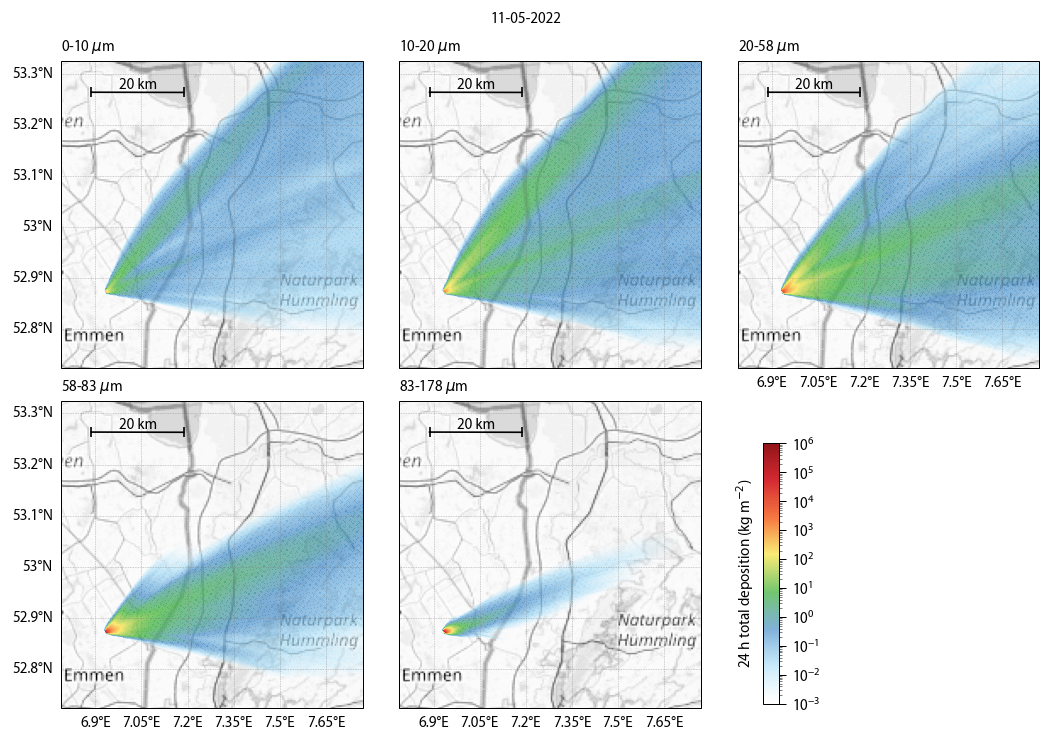

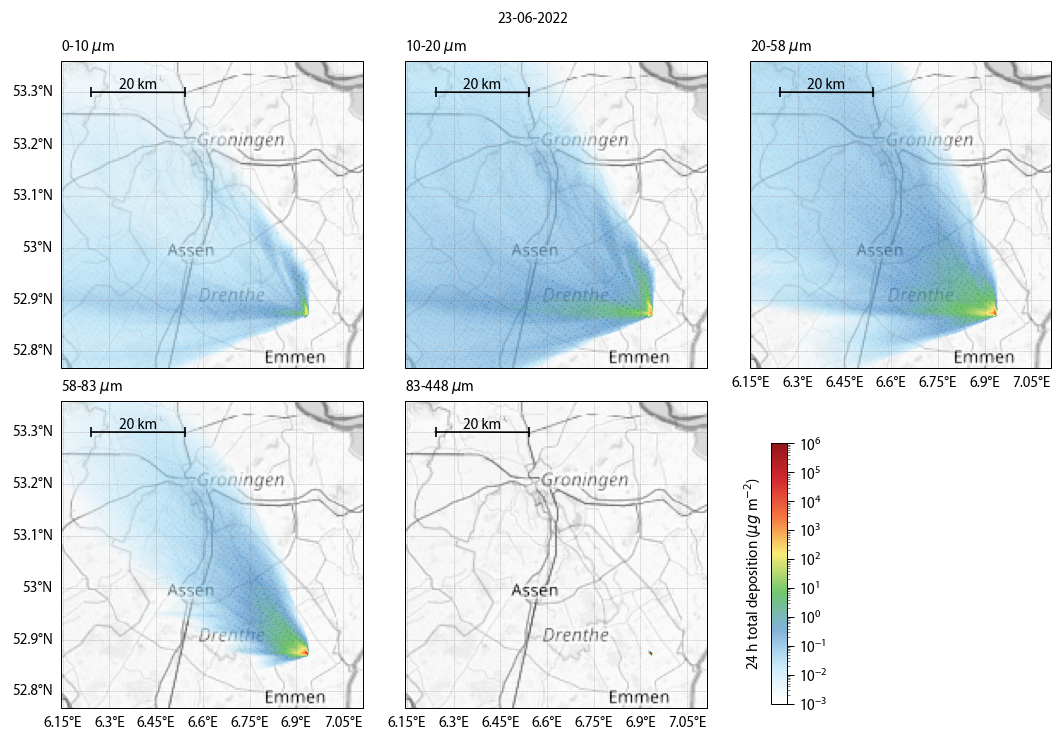

In [6]:
normalized = True

fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_bsne_normed(ds1, proj1, '0-10',   231, extent1, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds1, proj1, '10-20',  232, extent1, normed=normalized, labels=[])
pc=plot_bsne_normed(ds1, proj1, '20-58',  233, extent1, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds1, proj1, '58-83',  234, extent1, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds1, proj1, '83-178', 235, extent1, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition (kg m$^{-2}$)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_bsne_normed(ds2, proj2, '0-10',   231, extent2, normed=normalized, labels=['left'])
pc=plot_bsne_normed(ds2, proj2, '10-20',  232, extent2, normed=normalized, labels=[])
pc=plot_bsne_normed(ds2, proj2, '20-58',  233, extent2, normed=normalized, labels=['bottom'])
pc=plot_bsne_normed(ds2, proj2, '58-83',  234, extent2, normed=normalized, labels=['left', 'bottom'])
pc=plot_bsne_normed(ds2, proj2, '83-448', 235, extent2, normed=normalized, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h total deposition ($\mu g$ m$^{-2}$)', rotation=90)

## Local normalization.

Each dust size has a surface flux of 1 kg dust / m2 / s.

For each dust size, we calculate the 24 h mean deposition within a 500 m radius around the center of the field, and normalize the deposition with this value. 

Shows deposition as ratio large-scale / local transport.

In [7]:
"""
Calculate distance from center of field.
"""

lat_field = np.array([52.875833, 52.875278, 52.870833, 52.871389, 52.875833])
lon_field = np.array([6.932500, 6.931667, 6.937500, 6.938333, 6.932500])

# First/last coordinate twice in list, so remove last one.
central_lat = lat_field[:-1].mean()
central_lon = lon_field[:-1].mean()

def haversine_np(lon1, lat1, lon2, lat2):
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    return 6378137 * c


def calc_distance_mask(distance, radius, lon, lat):
    """
    Calculate mask, set to True within distance from field center.
    """
    return distance <= radius


def calc_field_mask(lon, lat):
    """
    Calculate mask set to True within bounds of the field.
    """
    jtot, itot = lon.shape
    mask = np.zeros_like(lon, dtype=np.bool)

    for j in range(jtot):
        for i in range(itot):
            if is_inside(lon[j,i], lat[j,i], lon_field, lat_field, lon_field.size):
                mask[j,i] = True

    return mask


# Distance each grid point to center of field.
d1 = haversine_np(central_lon, central_lat, proj1.lon, proj1.lat)
d2 = haversine_np(central_lon, central_lat, proj2.lon, proj2.lat)

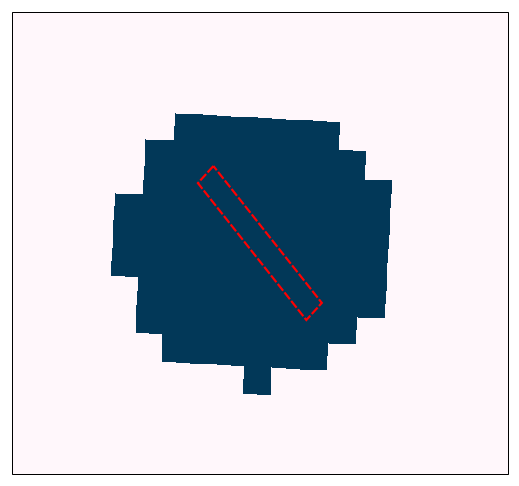

In [8]:
"""
Original: 500 m masked around center of field.
"""
mask_500m_1 = calc_distance_mask(d1, 500, proj1.lon, proj1.lat)
mask_500m_2 = calc_distance_mask(d2, 500, proj2.lon, proj2.lat)

pl.figure()
extent = [lon_field.min()-0.01, lon_field.max()+0.01, lat_field.min()-0.005, lat_field.max()+0.005]
ax = hlp.setup_map(extent, sp=111, zoom_level=9, use_osm=True)
pl.pcolormesh(proj1.lon, proj1.lat, mask_500m_1, cmap=pl.cm.PuBu, transform=ccrs.PlateCarree())
pl.plot(lon_field, lat_field, 'r--', transform=ccrs.PlateCarree())

Text(0, 0.5, '24 h relative deposition (%)')

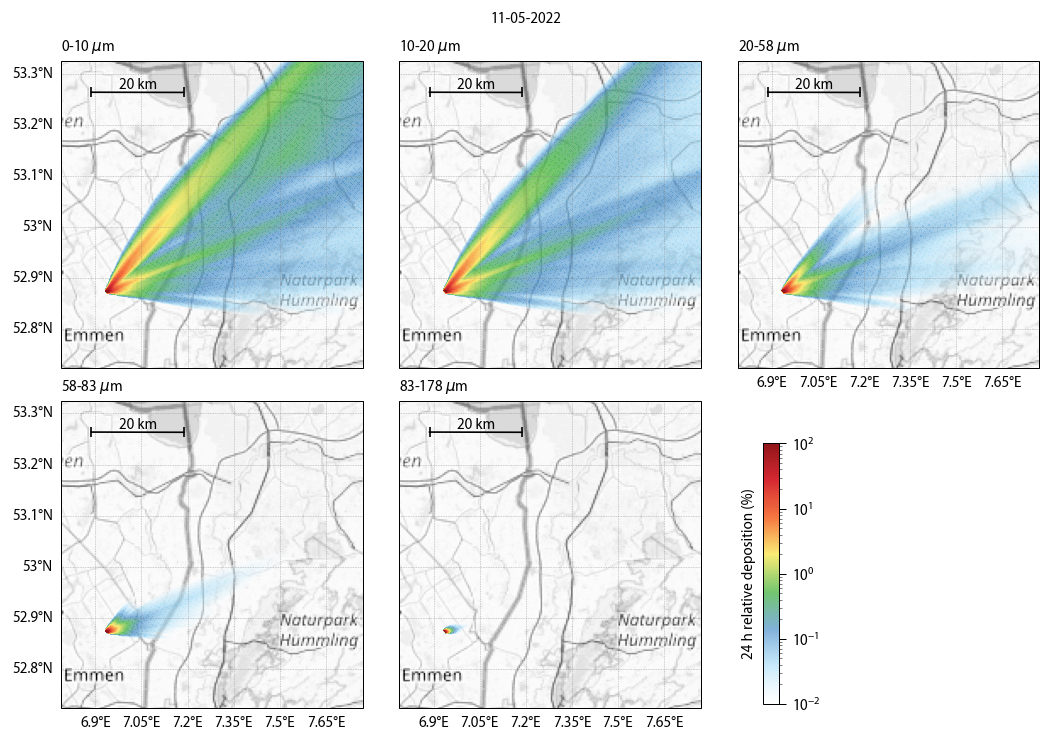

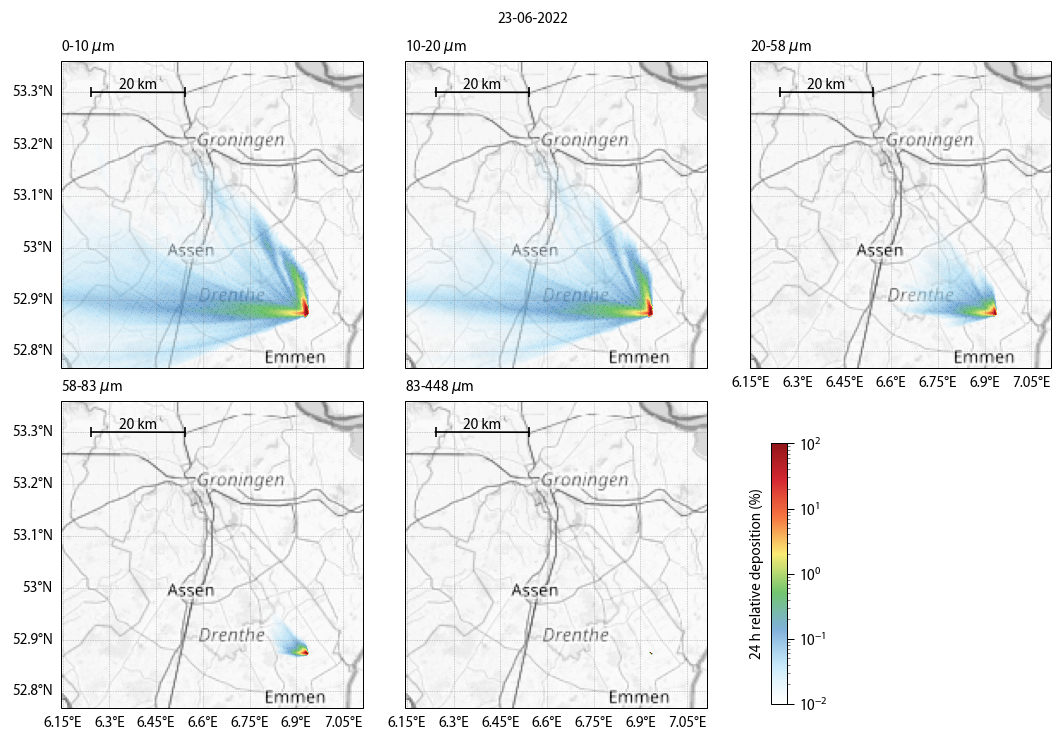

In [9]:
fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_local_normed(ds1, proj1, mask_500m_1, '0-10',   231, extent1, labels=['left'])
pc=plot_local_normed(ds1, proj1, mask_500m_1, '10-20',  232, extent1, labels=[])
pc=plot_local_normed(ds1, proj1, mask_500m_1, '20-58',  233, extent1, labels=['bottom'])
pc=plot_local_normed(ds1, proj1, mask_500m_1, '58-83',  234, extent1, labels=['left', 'bottom'])
pc=plot_local_normed(ds1, proj1, mask_500m_1, '83-178', 235, extent1, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_local_normed(ds2, proj2, mask_500m_2, '0-10',   231, extent2, labels=['left'])
pc=plot_local_normed(ds2, proj2, mask_500m_2, '10-20',  232, extent2, labels=[])
pc=plot_local_normed(ds2, proj2, mask_500m_2, '20-58',  233, extent2, labels=['bottom'])
pc=plot_local_normed(ds2, proj2, mask_500m_2, '58-83',  234, extent2, labels=['left', 'bottom'])
pc=plot_local_normed(ds2, proj2, mask_500m_2, '83-448', 235, extent2, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)

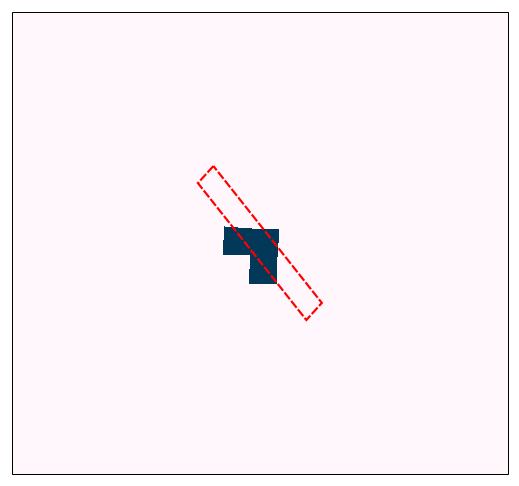

In [10]:
"""
Alternative 1: 100 m masked mean around center of field.
Resolution model is a bit too low for this...
"""
mask_100m_1 = calc_distance_mask(d1, 100, proj1.lon, proj1.lat)
mask_100m_2 = calc_distance_mask(d2, 100, proj2.lon, proj2.lat)

pl.figure()
extent = [lon_field.min()-0.01, lon_field.max()+0.01, lat_field.min()-0.005, lat_field.max()+0.005]
ax = hlp.setup_map(extent, sp=111, zoom_level=9, use_osm=True)
pl.pcolormesh(proj1.lon, proj1.lat, mask_100m_1, cmap=pl.cm.PuBu, transform=ccrs.PlateCarree())
pl.plot(lon_field, lat_field, 'r--', transform=ccrs.PlateCarree())

Text(0, 0.5, '24 h relative deposition (%)')

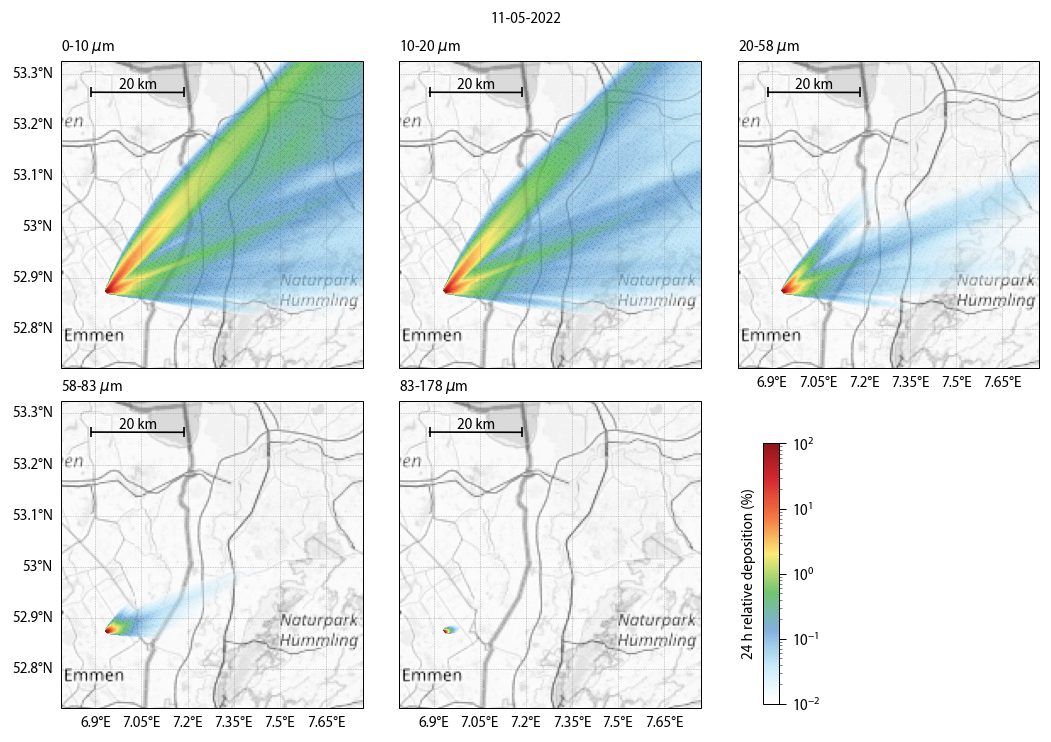

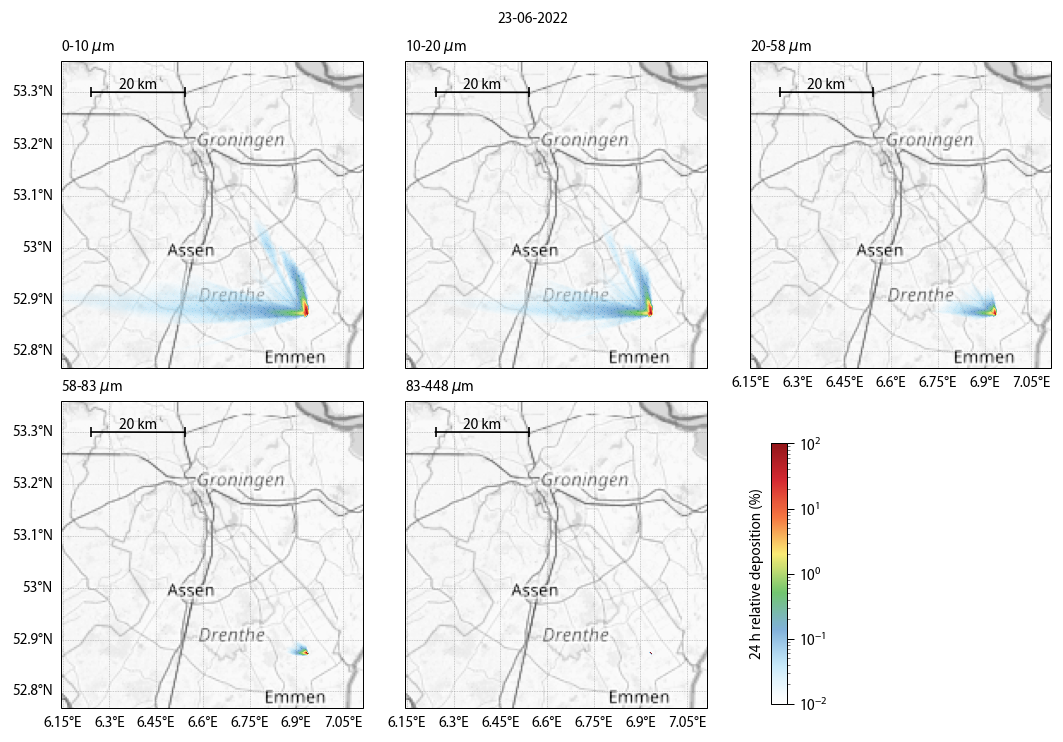

In [11]:
fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_local_normed(ds1, proj1, mask_100m_1, '0-10',   231, extent1, labels=['left'])
pc=plot_local_normed(ds1, proj1, mask_100m_1, '10-20',  232, extent1, labels=[])
pc=plot_local_normed(ds1, proj1, mask_100m_1, '20-58',  233, extent1, labels=['bottom'])
pc=plot_local_normed(ds1, proj1, mask_100m_1, '58-83',  234, extent1, labels=['left', 'bottom'])
pc=plot_local_normed(ds1, proj1, mask_100m_1, '83-178', 235, extent1, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_local_normed(ds2, proj2, mask_100m_2, '0-10',   231, extent2, labels=['left'])
pc=plot_local_normed(ds2, proj2, mask_100m_2, '10-20',  232, extent2, labels=[])
pc=plot_local_normed(ds2, proj2, mask_100m_2, '20-58',  233, extent2, labels=['bottom'])
pc=plot_local_normed(ds2, proj2, mask_100m_2, '58-83',  234, extent2, labels=['left', 'bottom'])
pc=plot_local_normed(ds2, proj2, mask_100m_2, '83-448', 235, extent2, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)

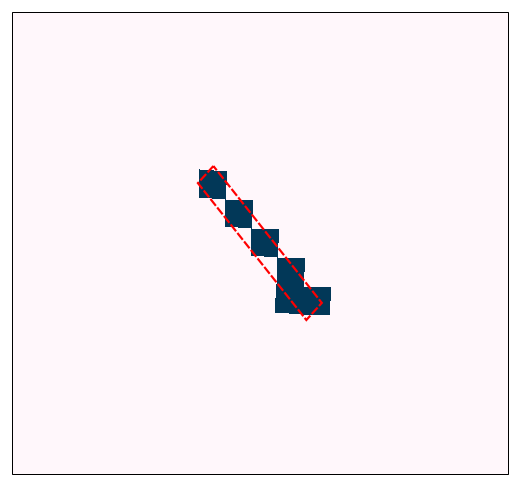

In [12]:
"""
Alternative 2: use field as mask..
Resolution is also a bit too low for this...
"""
mask_field_1 = calc_field_mask(proj1.lon, proj1.lat)
mask_field_2 = calc_field_mask(proj2.lon, proj2.lat)

pl.figure()
extent = [lon_field.min()-0.01, lon_field.max()+0.01, lat_field.min()-0.005, lat_field.max()+0.005]
ax = hlp.setup_map(extent, sp=111, zoom_level=9, use_osm=True)
pl.pcolormesh(proj1.lon, proj1.lat, mask_field_1, cmap=pl.cm.PuBu, transform=ccrs.PlateCarree())
pl.plot(lon_field, lat_field, 'r--', transform=ccrs.PlateCarree())

Text(0, 0.5, '24 h relative deposition (%)')

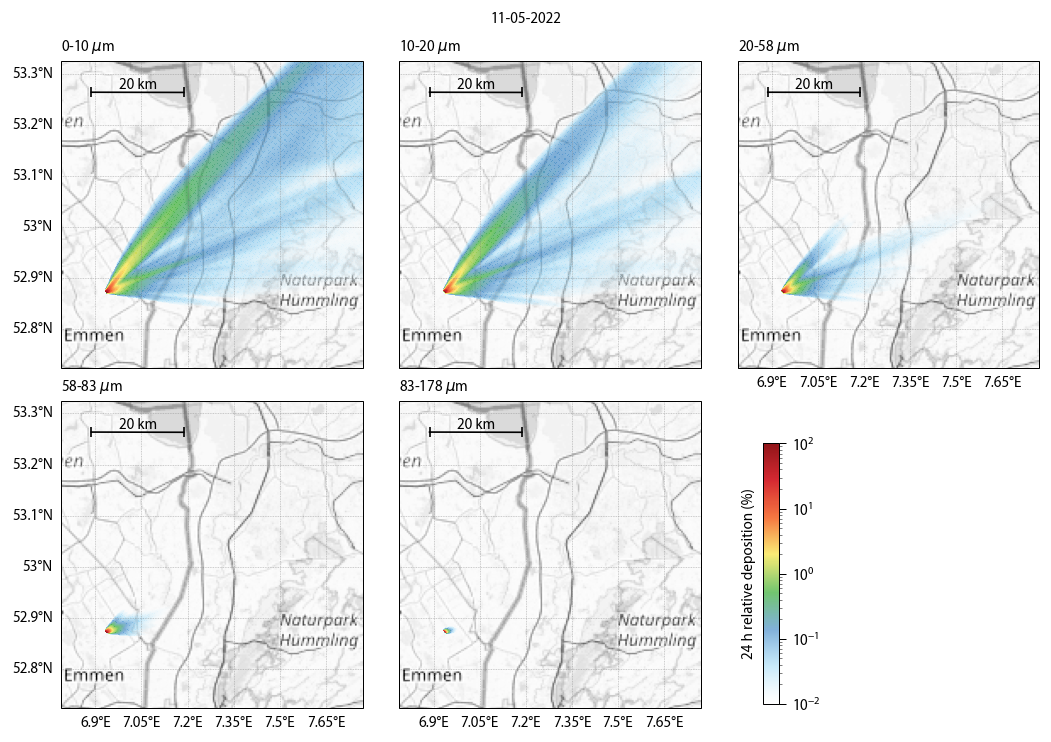

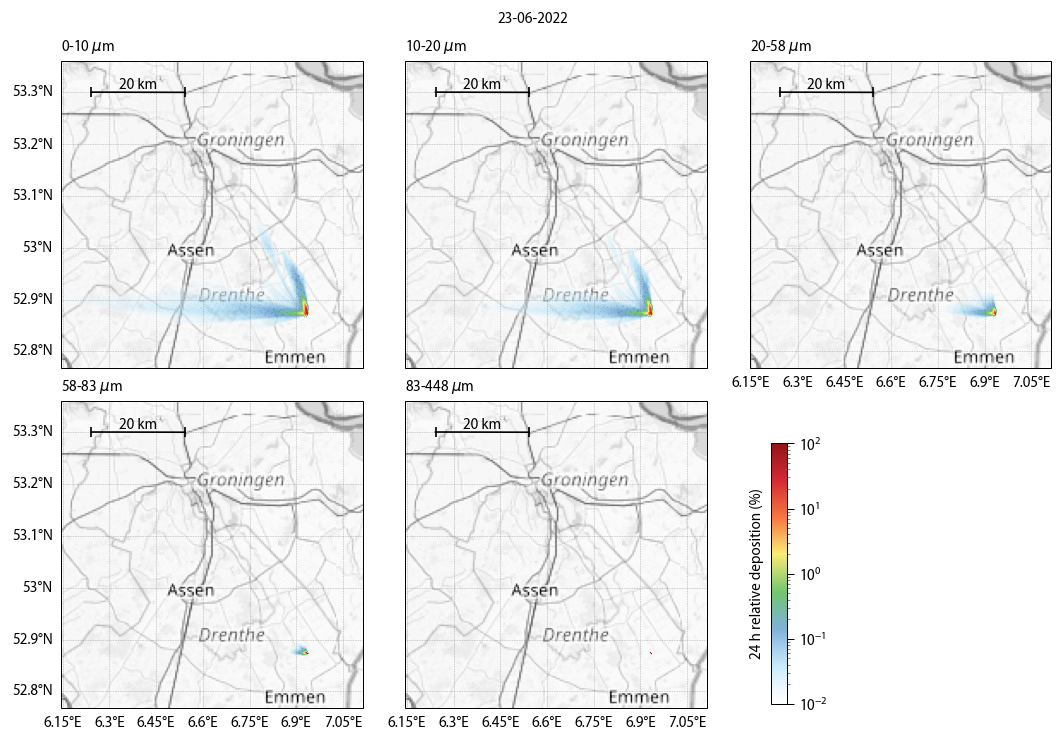

In [13]:
fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('11-05-2022')

pc=plot_local_normed(ds1, proj1, mask_field_1, '0-10',   231, extent1, labels=['left'])
pc=plot_local_normed(ds1, proj1, mask_field_1, '10-20',  232, extent1, labels=[])
pc=plot_local_normed(ds1, proj1, mask_field_1, '20-58',  233, extent1, labels=['bottom'])
pc=plot_local_normed(ds1, proj1, mask_field_1, '58-83',  234, extent1, labels=['left', 'bottom'])
pc=plot_local_normed(ds1, proj1, mask_field_1, '83-178', 235, extent1, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)


fig=pl.figure(figsize=(9, 6.2))
pl.suptitle('23-06-2022')

pc=plot_local_normed(ds2, proj2, mask_field_2, '0-10',   231, extent2, labels=['left'])
pc=plot_local_normed(ds2, proj2, mask_field_2, '10-20',  232, extent2, labels=[])
pc=plot_local_normed(ds2, proj2, mask_field_2, '20-58',  233, extent2, labels=['bottom'])
pc=plot_local_normed(ds2, proj2, mask_field_2, '58-83',  234, extent2, labels=['left', 'bottom'])
pc=plot_local_normed(ds2, proj2, mask_field_2, '83-448', 235, extent2, labels=['bottom'])

pl.tight_layout()

cax = fig.add_axes([0.72, 0.05, 0.015, 0.35])
cb = pl.colorbar(pc, cax=cax)
cb.ax.yaxis.set_label_position('left')
cb.ax.set_ylabel(r'24 h relative deposition (%)', rotation=90)